## Consumption prediction 소비예측  

1. import & Data Check
2. EDA
3. Feature engineering
4. Modeling & submission

## 1. import & Data Check

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
os.listdir('./dataset/customer')

['sample_submission.csv', 'test.csv', 'train.csv']

In [68]:
df_train = pd.read_csv('./dataset/customer/train.csv')
df_test = pd.read_csv('./dataset/customer/test.csv')

### 1) 데이터 확인

In [7]:
df_train.columns, df_test.columns

(Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'target'],
       dtype='object'),
 Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'],
       dtype='object'))

In [8]:
df_train.head() # 22개의 컬럼

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


In [10]:
df_train.shape, df_test.shape # 1108명의 고객

((1108, 22), (1108, 21))

In [74]:
# # numeric 과 categorical 변수로 나누기

numerical_features =df_train[['id', 'Year_Birth', 'Income', 'Kidhome',
        'Teenhome','Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth']].dtypes.index
print("numerical features : ",len(numerical_features))

categorical_features =df_train[['Education', 'Marital_Status', 'Dt_Customer','AcceptedCmp3',
                               'AcceptedCmp4', 'AcceptedCmp5',
                               'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']].dtypes.index
print("categorical features : ",len(categorical_features))

numerical features :  11
categorical features :  10


In [75]:
numerical_features

Index(['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth'],
      dtype='object')

### 2) 이상치 탐색 및 제거

In [36]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers

Outlier_to_drop = detect_outliers(df_train, 2,['id', 'Year_Birth', 'Income', 'Kidhome',
        'Teenhome','Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth'])
# target 제외 

In [37]:
df_train.loc[Outlier_to_drop]
# 이상치 없음

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target


### 3) 결측 데이터 확인

In [38]:
for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)
    
# 결측 데이터도 하나도 없음

column:         id	 Percent of NaN value: 0.00%
column: Year_Birth	 Percent of NaN value: 0.00%
column:  Education	 Percent of NaN value: 0.00%
column: Marital_Status	 Percent of NaN value: 0.00%
column:     Income	 Percent of NaN value: 0.00%
column:    Kidhome	 Percent of NaN value: 0.00%
column:   Teenhome	 Percent of NaN value: 0.00%
column: Dt_Customer	 Percent of NaN value: 0.00%
column:    Recency	 Percent of NaN value: 0.00%
column: NumDealsPurchases	 Percent of NaN value: 0.00%
column: NumWebPurchases	 Percent of NaN value: 0.00%
column: NumCatalogPurchases	 Percent of NaN value: 0.00%
column: NumStorePurchases	 Percent of NaN value: 0.00%
column: NumWebVisitsMonth	 Percent of NaN value: 0.00%
column: AcceptedCmp3	 Percent of NaN value: 0.00%
column: AcceptedCmp4	 Percent of NaN value: 0.00%
column: AcceptedCmp5	 Percent of NaN value: 0.00%
column: AcceptedCmp1	 Percent of NaN value: 0.00%
column: AcceptedCmp2	 Percent of NaN value: 0.00%
column:   Complain	 Percent of NaN val

In [39]:
for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

column:         id	 Percent of NaN value: 0.00%
column: Year_Birth	 Percent of NaN value: 0.00%
column:  Education	 Percent of NaN value: 0.00%
column: Marital_Status	 Percent of NaN value: 0.00%
column:     Income	 Percent of NaN value: 0.00%
column:    Kidhome	 Percent of NaN value: 0.00%
column:   Teenhome	 Percent of NaN value: 0.00%
column: Dt_Customer	 Percent of NaN value: 0.00%
column:    Recency	 Percent of NaN value: 0.00%
column: NumDealsPurchases	 Percent of NaN value: 0.00%
column: NumWebPurchases	 Percent of NaN value: 0.00%
column: NumCatalogPurchases	 Percent of NaN value: 0.00%
column: NumStorePurchases	 Percent of NaN value: 0.00%
column: NumWebVisitsMonth	 Percent of NaN value: 0.00%
column: AcceptedCmp3	 Percent of NaN value: 0.00%
column: AcceptedCmp4	 Percent of NaN value: 0.00%
column: AcceptedCmp5	 Percent of NaN value: 0.00%
column: AcceptedCmp1	 Percent of NaN value: 0.00%
column: AcceptedCmp2	 Percent of NaN value: 0.00%
column:   Complain	 Percent of NaN val

### 4) 비대칭성 확인 - numeric 변수에 해당

In [49]:
numerical_features

Index(['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'target'],
      dtype='object')

In [48]:
for col in numerical_features:
    print('{:15}'.format(col),
          'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '  ', 
         'Kurtosis : {:06.2f}'.format(df_train[col].kurt()),)

id              Skewness : 00.00    Kurtosis : -01.20
Year_Birth      Skewness : -0.44    Kurtosis : 001.19
Income          Skewness : 00.29    Kurtosis : 000.60
Kidhome         Skewness : 00.77    Kurtosis : -00.52
Teenhome        Skewness : 00.44    Kurtosis : -00.90
Recency         Skewness : -0.06    Kurtosis : -01.21
NumDealsPurchases Skewness : 02.26    Kurtosis : 007.73
NumWebPurchases Skewness : 01.29    Kurtosis : 004.92
NumCatalogPurchases Skewness : 01.10    Kurtosis : 000.38
NumStorePurchases Skewness : 00.65    Kurtosis : -00.76
NumWebVisitsMonth Skewness : 00.30    Kurtosis : 002.35
AcceptedCmp3    Skewness : 03.39    Kurtosis : 009.51
AcceptedCmp4    Skewness : 02.96    Kurtosis : 006.79
AcceptedCmp5    Skewness : 03.31    Kurtosis : 008.97
AcceptedCmp1    Skewness : 03.42    Kurtosis : 009.70
AcceptedCmp2    Skewness : 07.90    Kurtosis : 060.47
Complain        Skewness : 10.40    Kurtosis : 106.29
Response        Skewness : 02.06    Kurtosis : 002.24
target          Sk

In [52]:
df_train.info()
# object - Education,Marital_Status,Dt_Customer     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

#### Dt_Customer 분리하기

In [76]:
def seperate_datetime(dataframe):
    year, month, day = [],[],[]

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

In [77]:
year, month, day = seperate_datetime(df_train)
    
df_train['year'] = year
df_train['month'] = month
df_train['day'] = day

df_train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,10,6,2014


In [78]:
df_train = df_train.drop('Dt_Customer', axis = 1)

In [79]:
df_train

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,Graduation,Single,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,Graduation,Married,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,Basic,Married,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,PhD,Together,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,10,6,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1103,1956,Graduation,Together,46097.0,0,1,11,5,3,...,0,0,0,0,0,0,241,31,3,2013
1104,1104,1986,Graduation,Married,23477.0,1,0,39,3,3,...,0,0,0,0,0,0,147,21,10,2013
1105,1105,1975,Master,Married,37368.0,1,0,4,1,1,...,0,0,0,0,0,0,30,16,12,2013
1106,1106,1974,Graduation,Divorced,53034.0,1,1,30,8,6,...,0,0,0,0,0,0,447,30,5,2013


In [80]:
# test도 동일하게 처리
year, month, day = seperate_datetime(df_test)
df_test['year'] = year
df_test['month'] = month
df_test['day'] = day
df_test = df_test.drop('Dt_Customer', axis = 1)

In [81]:
df_test

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,year,month,day
0,0,1979,Graduation,Single,57537.0,1,0,83,4,4,...,0,0,0,0,0,0,0,10,6,2013
1,1,1955,Graduation,Together,65748.0,0,1,58,2,2,...,0,0,0,0,0,1,0,15,4,2013
2,2,1984,Graduation,Married,55434.0,1,0,21,3,5,...,0,0,0,0,0,0,0,5,10,2013
3,3,1960,Graduation,Married,67716.0,0,1,8,4,7,...,0,1,0,0,0,0,0,10,1,2013
4,4,1976,Graduation,Together,85606.0,0,1,89,2,6,...,0,0,0,1,0,0,0,12,11,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1103,1952,Graduation,Married,35704.0,1,1,54,3,2,...,0,0,0,0,0,0,0,3,1,2014
1104,1104,1969,Master,Together,35924.0,1,1,56,1,1,...,0,0,0,0,0,0,0,23,3,2014
1105,1105,1989,PhD,Single,33996.0,0,0,46,1,1,...,0,0,0,0,0,0,0,11,9,2013
1106,1106,1970,Graduation,Together,74854.0,1,2,90,7,2,...,0,0,0,0,0,0,0,8,4,2013


#### Education, Marital_Status 라벨링

In [82]:
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

In [83]:
le = make_label_map(df_train)
df_train = label_encoder(df_train, le)
df_train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,0,0,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,1,1,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,1,2,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,2,2,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,3,0,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,10,6,2014


## 2. EDA

### 1) Numerical Feature  

수치형 데이터들을 알아보기 위한 plot

In [84]:
numerical_features

Index(['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth'],
      dtype='object')

### Correlation Heat Map

In [85]:
corr_data = df_train[['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'target']]

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

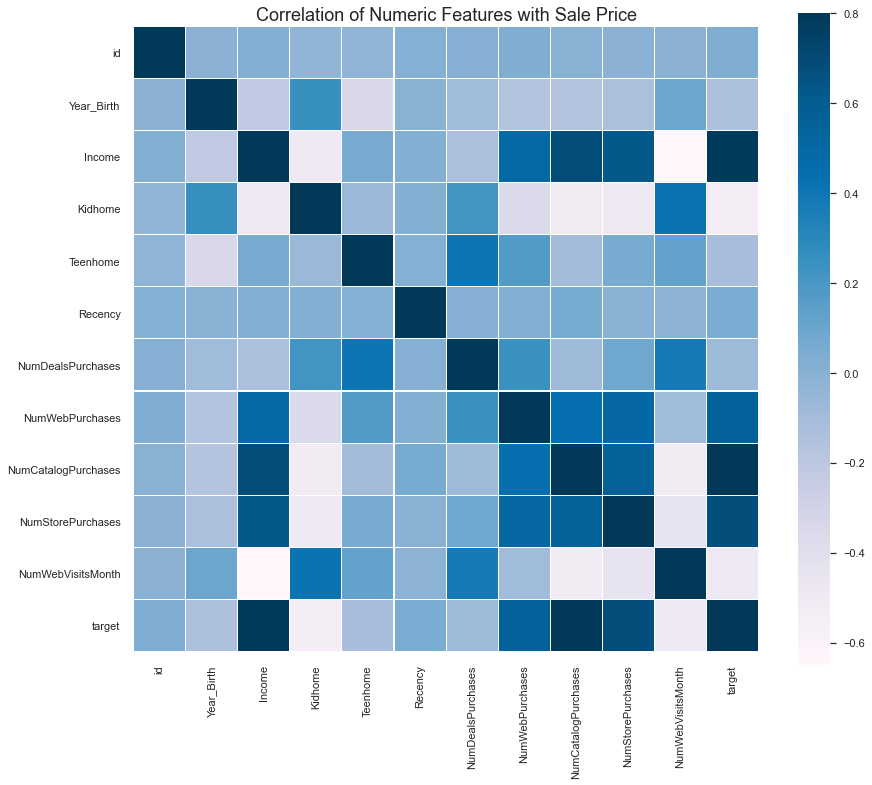

In [86]:
colormap = plt.cm.PuBu
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price', y= 1, size=18)

sns.heatmap(corr_data.corr(), square = True, linewidths = 0.1, 
            cmap = colormap, linecolor = 'white', vmax = 0.8)

In [ ]:
k = 11
cols = corr_data.corr().nlargest(k, 'target')['target'].index

<AxesSubplot:>

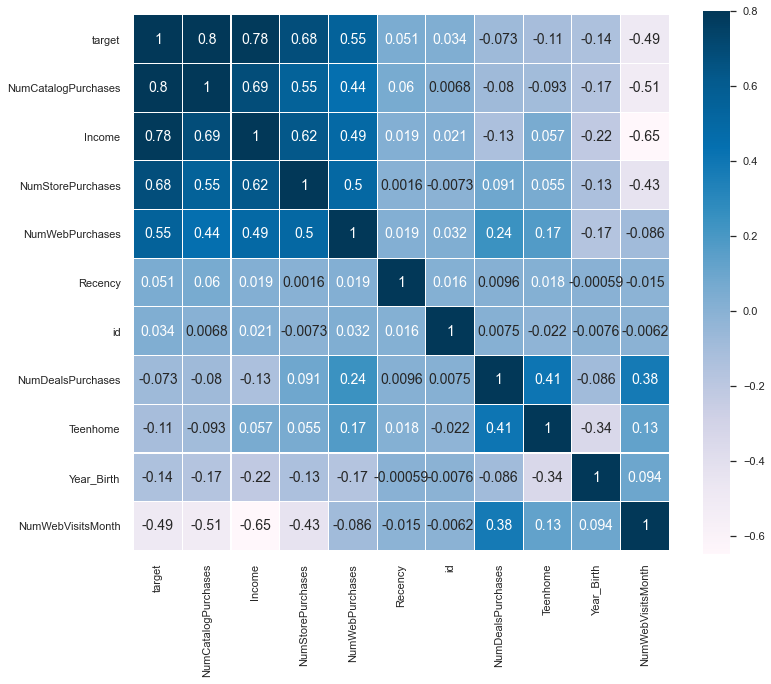

In [88]:
cm = np.corrcoef(df_train[cols].values.T)
f,ax = plt.subplots(figsize = (12,10))

sns.heatmap(cm, vmax=.8, linewidths = 0.1, square=True, annot = True, cmap=colormap,
           linecolor = 'white', xticklabels= cols.values, annot_kws = {'size':14},
           yticklabels = cols.values)

NumCatalogPurchases : 카탈로그를 사용한 구매 수 
Income : 고객 연간 가구 소득
NumStorePuchases : 매장에서 직접 구매한 횟수
NumWebPurchases : 회사 웹사이트를 통한 구매 건수
이 네가지 변수들도 서로 연관이 있어보임 아무래도.
그래도 삭제하기는 아직 이르네여

글고 scatter 플랏 그려보고 나서 범주형 자료의 형태를 띈다고 판단할 수 도 있었음



### 2) Categorical Feature  

범주형 데이터들을 알아보기 위해

In [89]:
categorical_features

Index(['Education', 'Marital_Status', 'Dt_Customer', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response'],
      dtype='object')

In [93]:
categorical_features =df_train[['Education', 'Marital_Status', 'AcceptedCmp3',
                               'AcceptedCmp4', 'AcceptedCmp5',
                               'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']].dtypes.index

In [94]:
for catg in list(categorical_features):
    print(df_train[catg].value_counts())
    print('*'*50)

1    570
3    254
0    173
4     89
2     22
Name: Education, dtype: int64
**************************************************
2    415
0    296
1    234
4    120
3     39
5      2
6      1
7      1
Name: Marital_Status, dtype: int64
**************************************************
0    1031
1      77
Name: AcceptedCmp3, dtype: int64
**************************************************
0    1013
1      95
Name: AcceptedCmp4, dtype: int64
**************************************************
0    1028
1      80
Name: AcceptedCmp5, dtype: int64
**************************************************
0    1032
1      76
Name: AcceptedCmp1, dtype: int64
**************************************************
0    1091
1      17
Name: AcceptedCmp2, dtype: int64
**************************************************
0    1098
1      10
Name: Complain, dtype: int64
**************************************************
0    951
1    157
Name: Response, dtype: int64
*************************************************

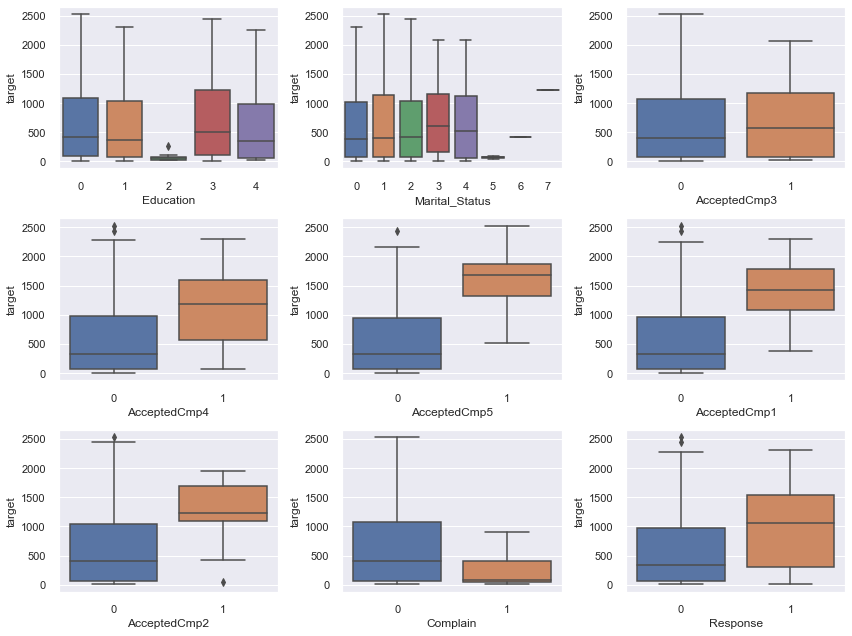

In [98]:
li_cat_feats = list(categorical_features)
nr_rows = 3
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r * nr_cols + c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=df_train['target'], data=df_train, ax=axs[r][c])
plt.tight_layout()
plt.show()

변수들을 따로 나눠서 저장하기
1. 그 범주가 어떤 값을 가지는 지 확인하는 코드 있었는데 찾아보기
2. 분석 과정이 부드럽고 자연스럽게 이어지도록 수정
3. linear Regression이 적합할까? 아니면 로지스틱이 맞을까 생각해보기


## 3. Feature engineering

## 4. Modeling & submission